# Pandemic statistics of Shanghai

## Get data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [2]:
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(URL, on_bad_lines="skip")
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/4/22,11/5/22,11/6/22,11/7/22,11/8/22,11/9/22,11/10/22,11/11/22,11/12/22,11/13/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,203497,203574,203681,203829,203942,204094,204287,204392,204417,204510
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,333027,333046,333055,333058,333071,333088,333103,333125,333138,333156
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,270856,270862,270873,270881,270891,270906,270917,270924,270929,270939
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,46588,46588,46588,46588,46588,46664,46664,46664,46664,46664
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,103131,103131,103131,103131,103131,103131,103131,103131,103131,103131


In [3]:
df[df["Province/State"] == "Shanghai"].iloc[0, 4:]

1/22/20         9
1/23/20        16
1/24/20        20
1/25/20        33
1/26/20        40
            ...  
11/9/22     64326
11/10/22    64328
11/11/22    64331
11/12/22    64334
11/13/22    64339
Name: 84, Length: 1027, dtype: object

In [4]:
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

def get_reported_cases_sh(URL=URL):
    df = pd.read_csv(URL, on_bad_lines="skip")
    df_sh = df[df["Province/State"] == "Shanghai"]
    cases_sh = df_sh.iloc[0, 4:]
    data = pd.DataFrame(
        data=cases_sh.values.reshape((-1, 1)),
        index=cases_sh.index,
        columns=["Total Confirmed Cases"]
    )
    data.index.name = "Date"
    return data

data = get_reported_cases_sh()
data

,Total Confirmed Cases
Date,
1/22/20,9
1/23/20,16
1/24/20,20
1/25/20,33
1/26/20,40
...,...
11/9/22,64326
11/10/22,64328
11/11/22,64331


In [5]:
data["Daily Confirmed Cases"] = data["Total Confirmed Cases"].diff(1)
data

,Total Confirmed Cases,Daily Confirmed Cases
Date,,
1/22/20,9,NaN
1/23/20,16,7
1/24/20,20,4
1/25/20,33,13
1/26/20,40,7
...,...,...
11/9/22,64326,3
11/10/22,64328,2
11/11/22,64331,3


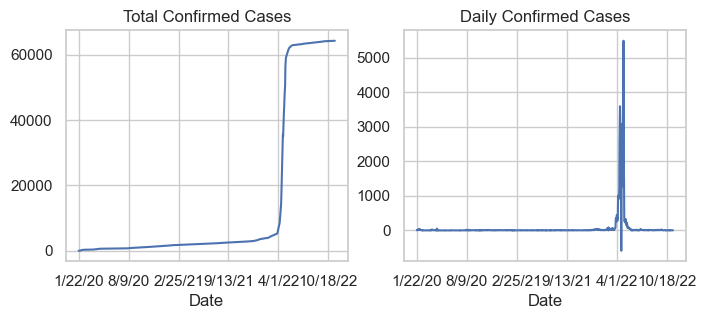

In [6]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
data["Total Confirmed Cases"].plot(ax=axes[0], title="Total Confirmed Cases")
data["Daily Confirmed Cases"].plot(ax=axes[1], title="Daily Confirmed Cases")
plt.show()


## Clean data

### Negative data

In [7]:
print(f"Number of negative items: {np.sum(data['Daily Confirmed Cases'] < 0)}")
print(f"Index of negative items: {np.where(data['Daily Confirmed Cases'] < 0)}")

Number of negative items: 1
Index of negative items: (array([819], dtype=int64),)


In [8]:
data.iloc[817:821]

,Total Confirmed Cases,Daily Confirmed Cases
Date,,
4/18/22,32584,3084
4/19/22,35668,3084
4/20/22,35079,-589
4/21/22,37714,2635


Fill `Total Confirmed Cases` on `4/18/22` with mean of the previous and next day's value 

In [9]:
T = data["Total Confirmed Cases"]
mean = (T.at["4/19/22"] + T.at["4/21/22"]) // 2
data.at["4/20/22", "Total Confirmed Cases"] = mean
data["Daily Confirmed Cases"] = data["Total Confirmed Cases"].diff(1)
print(f"Number of negative items: {np.sum(data['Daily Confirmed Cases'] < 0)}")

Number of negative items: 0


### Outlier

We are interested in the outbreak from March to June, 2022 

In [15]:
def parse_date(date: str):
    month, day, year = date.split("/")
    monthDict = {"1": "Jan.", "2": "Feb.", "3": "March", "4": "April", "5": "May", "6": "June", "7": "July", "8": "Aug.", "9": "Sept.", "10": "Oct.", "11": "Nov.", "12": "Dec."}
    return f"{monthDict[month]} {day}"


class Shanghai:
    def __init__(
        self,
        URL="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
    ):
        self.URL = URL
        self.dates = []
        self.C = []
        self.data = []

    def get_raw_data_sh(self, start=680, end=869):
        df = pd.read_csv(self.URL, on_bad_lines="skip")
        df_sh = df[df["Province/State"]=="Shanghai"]
        cases_sh = df_sh.iloc[:, 4:]
        data = pd.DataFrame(
            data=cases_sh.values.reshape((-1, 1)),
            index=cases_sh.columns,
            columns=["Total Confirmed Cases"]
        )
        data.index.name = "Date"

        # clean negative data
        T = data["Total Confirmed Cases"]
        mean = (T.at["4/19/22"] + T.at["4/21/22"]) // 2
        data.at["4/20/22", "Total Confirmed Cases"] = mean
        data["Daily Confirmed Cases"] = data["Total Confirmed Cases"].diff(1)
        
        # use data from Feb. 15, 2022 to June 8, 2022
        self.data = data.iloc[start:end, :]
        self.dates = [parse_date(date) for date in data.index]
        self.C = self.data["Daily Confirmed Cases"].to_list()

In [16]:
sh = Shanghai()
sh.get_raw_data_sh()
sh.dates

['Jan. 22',
 'Jan. 23',
 'Jan. 24',
 'Jan. 25',
 'Jan. 26',
 'Jan. 27',
 'Jan. 28',
 'Jan. 29',
 'Jan. 30',
 'Jan. 31',
 'Feb. 1',
 'Feb. 2',
 'Feb. 3',
 'Feb. 4',
 'Feb. 5',
 'Feb. 6',
 'Feb. 7',
 'Feb. 8',
 'Feb. 9',
 'Feb. 10',
 'Feb. 11',
 'Feb. 12',
 'Feb. 13',
 'Feb. 14',
 'Feb. 15',
 'Feb. 16',
 'Feb. 17',
 'Feb. 18',
 'Feb. 19',
 'Feb. 20',
 'Feb. 21',
 'Feb. 22',
 'Feb. 23',
 'Feb. 24',
 'Feb. 25',
 'Feb. 26',
 'Feb. 27',
 'Feb. 28',
 'Feb. 29',
 'March 1',
 'March 2',
 'March 3',
 'March 4',
 'March 5',
 'March 6',
 'March 7',
 'March 8',
 'March 9',
 'March 10',
 'March 11',
 'March 12',
 'March 13',
 'March 14',
 'March 15',
 'March 16',
 'March 17',
 'March 18',
 'March 19',
 'March 20',
 'March 21',
 'March 22',
 'March 23',
 'March 24',
 'March 25',
 'March 26',
 'March 27',
 'March 28',
 'March 29',
 'March 30',
 'March 31',
 'April 1',
 'April 2',
 'April 3',
 'April 4',
 'April 5',
 'April 6',
 'April 7',
 'April 8',
 'April 9',
 'April 10',
 'April 11',
 'April 12',


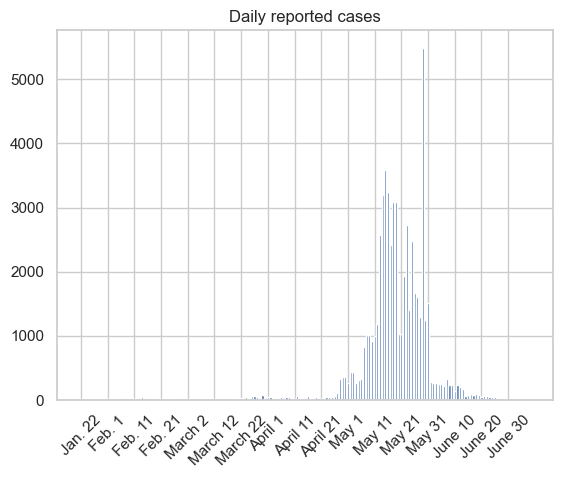

In [14]:
plt.bar(range(len(sh.C)), sh.C)
plt.title("Daily reported cases")
ticks = np.arange(0, len(sh.C), 10)
labels = [sh.dates[i] for i in ticks]
plt.xticks(ticks=ticks, labels=labels, rotation=45)

plt.show()

An outlier over 5000 occured at the begin of April.

In [75]:
idx = np.argwhere(np.array(sh.C)>5000).item()
sh.dates[idx]

'April 4'

Replace the outlier with the mean of adjacent values.

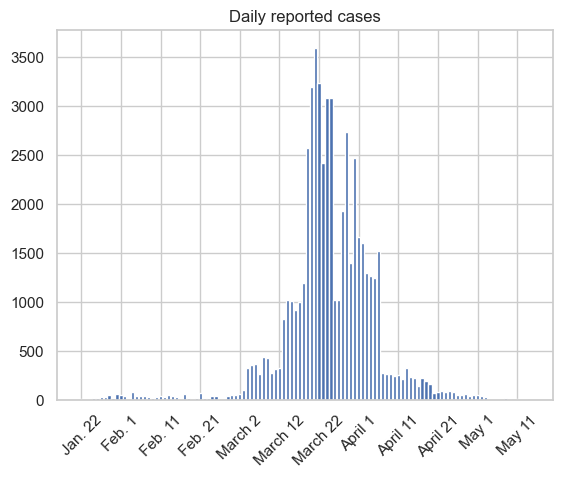

In [77]:
sh.C[idx] = (sh.C[idx-1] + sh.C[idx+1]) // 2

plt.bar(range(len(sh.C)), sh.C)
plt.title("Daily reported cases")
ticks = np.arange(0, len(sh.C), 10)
labels = [sh.dates[i] for i in ticks]
plt.xticks(ticks=ticks, labels=labels, rotation=45)

plt.show()

### Full raw data processing pipeline

In [196]:
def parse_date(date: str):
    month, day, year = date.split("/")
    monthDict = {"1": "Jan.", "2": "Feb.", "3": "March", "4": "April", "5": "May", "6": "June", "7": "July", "8": "Aug.", "9": "Sept.", "10": "Oct.", "11": "Nov.", "12": "Dec."}
    return f"{monthDict[month]} {day}"


class Shanghai:
    def __init__(
        self,
        URL="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
    ):
        self.URL = URL
        self.dates = np.array([])
        self.C = np.array([])
        self.data = pd.DataFrame()

    def load_data(self, start=755, end=869):
        df = pd.read_csv(self.URL, on_bad_lines="skip")
        df_sh = df[df["Province/State"]=="Shanghai"]
        cases_sh = df_sh.iloc[:, 4:]
        data = pd.DataFrame(
            data=cases_sh.values.reshape((-1, 1)),
            index=cases_sh.columns,
            columns=["Total Confirmed Cases"]
        )
        data.index.name = "Date"
        data["Daily Confirmed Cases"] = data["Total Confirmed Cases"].diff(1)
   
        # clean negative data
        T = data["Total Confirmed Cases"].to_list()
        for i in [np.argwhere((data["Daily Confirmed Cases"] < 0).to_list()).item()]:
            mean = (T[i-1] + T[i+1]) // 2
            data.at[data.index[i], "Total Confirmed Cases"] = mean
        data["Daily Confirmed Cases"] = data["Total Confirmed Cases"].diff(1)

        # use data from Feb. 15, 2022 to June 8, 2022
        self.data = data.iloc[start:end, :]
        self.dates = np.array([parse_date(date) for date in self.data.index])
        self.C = self.data["Daily Confirmed Cases"].to_numpy()
    
        # replace outlier over 5000 with the mean of adjacent values
        idx = np.argwhere(np.array(sh.C)>5000).item()
        sh.C[idx] = (sh.C[idx-1] + sh.C[idx+1]) // 2


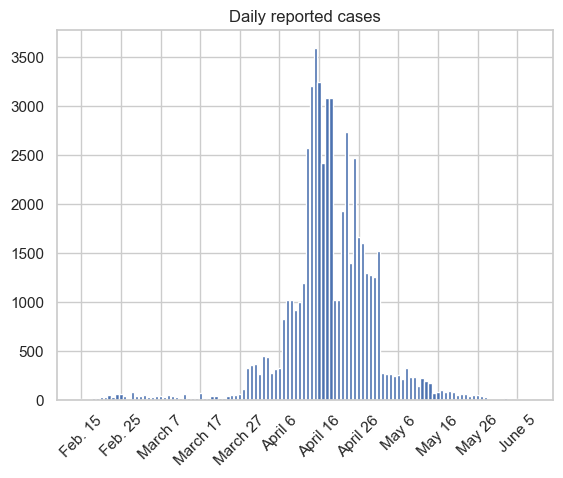

In [198]:
sh = Shanghai()
sh.load_data()

plt.bar(range(len(sh.C)), sh.C)
plt.title("Daily reported cases")
ticks = np.arange(0, len(sh.C), 10)
labels = [sh.dates[i] for i in ticks]
plt.xticks(ticks=ticks, labels=labels, rotation=45)

plt.show()

## Prepare date segments

Infections depends on current parameters and past data. In each time step, we need to pass current infections and past data to the likelihood function. However, in the transmission model, days of secondary infection are bounded and we also trucated infectiousness profile by infectiousness bound to introduce external interventions. So we do not need to pass all past data. Instead, a sequence of past data with a length the same as infectious profile would be sufficient.
```
[
    [I2, [I1, 0, 0, ...]],
    [I3, [I1, I2, 0, ...],]
    [I4, [I1, I2, I3, ...],
    ...
]
```

In [208]:
class Shanghai:
    def __init__(
        self,
        URL="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
        beta=[0.01355014, 0.03523035, 0.08130081, 0.14905149, 0.1897019, 0.21680217, 0.13550136, 0.08130081, 0.05420054, 0.02710027, 0.01355014, 0.00271003],
    ):
        self.URL = URL
        self.beta = np.array(beta)
        self.dates = np.array([])
        self.C = np.array([])
        self.data = pd.DataFrame()

    def load_data(self, start=755, end=869):
        df = pd.read_csv(self.URL, on_bad_lines="skip")
        df_sh = df[df["Province/State"]=="Shanghai"]
        cases_sh = df_sh.iloc[:, 4:]
        data = pd.DataFrame(
            data=cases_sh.values.reshape((-1, 1)),
            index=cases_sh.columns,
            columns=["Total Confirmed Cases"]
        )
        data.index.name = "Date"
        data["Daily Confirmed Cases"] = data["Total Confirmed Cases"].diff(1)
   
        # clean negative data
        T = data["Total Confirmed Cases"].to_list()
        for i in [np.argwhere((data["Daily Confirmed Cases"] < 0).to_list()).item()]:
            mean = (T[i-1] + T[i+1]) // 2
            data.at[data.index[i], "Total Confirmed Cases"] = mean
        data["Daily Confirmed Cases"] = data["Total Confirmed Cases"].diff(1)

        # use data from Feb. 15, 2022 to June 8, 2022
        self.data = data.iloc[start:end, :]
        self.dates = np.array([parse_date(date) for date in self.data.index])
        self.C = self.data["Daily Confirmed Cases"].to_numpy()
    
        # replace outlier over 5000 with the mean of adjacent values
        idx = np.argwhere(np.array(sh.C)>5000).item()
        sh.C[idx] = (sh.C[idx-1] + sh.C[idx+1]) // 2

    def get_data_seg(self):
        if len(self.C) == 0:
            self.load_data()
        N = len(self.beta)
        data_seg = np.empty((len(self.C)-N+1, N))
        for i in range(data_seg.shape[0]):
            data_seg[i, :] = self.C[i:i+N][::-1]
        self.dates = self.dates[N-1:]
        self.C = self.C[N-1:]
        self.data_seg = data_seg
        return data_seg

In [209]:
sh = Shanghai()
sh.get_data_seg()

array([[43., 55., 59., ..., 13.,  9., 13.],
       [ 0., 43., 55., ..., 18., 13.,  9.],
       [85.,  0., 43., ..., 23., 18., 13.],
       ...,
       [10.,  7.,  0., ..., 32., 39., 46.],
       [12., 10.,  7., ...,  6., 32., 39.],
       [ 4., 12., 10., ..., 13.,  6., 32.]])